### Session Creation

In [1]:
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col


connection_parameters = {
    "account": "<your snowflake account identifier>",
    "user": "<your snowflake username>",
    "password": "<your snowflake password>",
    "role": "<your snowflake role>",
    "warehouse": "<your snowflake warehouse>",  # optional
    "database": "<your snowflake database>",  # optional
    "schema": "<your snowflake schema>" # optional
  }


# it is best practice to not use/save your credentials in a jupyter notebook
# In this case I'm loading my credentials as a dictionary
import os
connection_parameters = {
    "account": os.getenv('SNOWFLAKE_ACCOUNT'),
    "user": os.getenv('SNOWFLAKE_USER'),
    "password": os.getenv('SNOWFLAKE_PASSWORD'),
    "role": os.getenv('SNOWFLAKE_ROLE'),
    "warehouse": os.getenv("SNOWFLAKE_WAREHOUSE"),  # optional
    "database": "SNOWPARK",  # optional
    "schema": "TUTORIAL" # optional
  }


session = Session.builder.configs(connection_parameters).create()

In [2]:
FEATURE_LIST = [ "HOLIDAY", "WORKINGDAY", "WEEKDAY", "HOUR", "HUMIDITY", "MONTH", "TEMP", "ATEMP", "WINDSPEED", "SEASON", "WEATHER"]
LABEL_COLUMNS = ['COUNT']
OUTPUT_COLUMNS = ['PREDICTED_COUNT']

df = session.table("MODEL_DATA")
df = df.drop("DATETIME","DATE")
df.show(2)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"  |"CASUAL"  |"REGISTERED"  |"COUNT"  |"HOUR"  |"MONTH"  |"WEEKDAY"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1         |0          |0             |1          |9.84    |14.395   |81          |0.0000       |3         |13            |16       |0       |1        |6          |
|1         |0          |0             |1          |9.02    |13.635   |80          |0.0000       |8         |32            |40       |1       |1        |6          |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------



### Preparing the Model -  XGBoost

* Code block delineates building XGboost model by optimizing two parameters through Gridsearch
* Contains code snippets to find optimal model parameters - max_depth & min_child_weight

In [3]:
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.modeling.xgboost import XGBRegressor

param_grid = {
        "max_depth":[3, 4, 5, 6, 7, 8],
        "min_child_weight":[1, 2, 3, 4],
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=param_grid,
    n_jobs = -1,
    scoring="neg_root_mean_squared_error",
    input_cols=FEATURE_LIST,
    label_cols=LABEL_COLUMNS,
    output_cols=['PREDICTED_COUNT']
)

In [4]:

train_df, test_df = df.random_split(weights=[0.7, 0.3], seed=0) 

grid_search.fit(train_df)

C:\Users\Preston\anaconda3\envs\python310\lib\site-packages\snowflake\ml\_internal\utils\snowpark_dataframe_utils.py:88: UserWarning: Warning: The Decimal(38, 2) data type is being automatically converted to DoubleType in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  warnings.warn(
C:\Users\Preston\anaconda3\envs\python310\lib\site-packages\snowflake\ml\_internal\utils\snowpark_dataframe_utils.py:88: UserWarning: Warning: The Decimal(38, 3) data type is being automatically converted to DoubleType in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  warnings.warn(
C:\Users\Preston\anaconda3\envs\python310\lib\site-packages\snowflake\ml\_internal\utils\snowpark_

In [5]:
grid_search.to_sklearn().best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

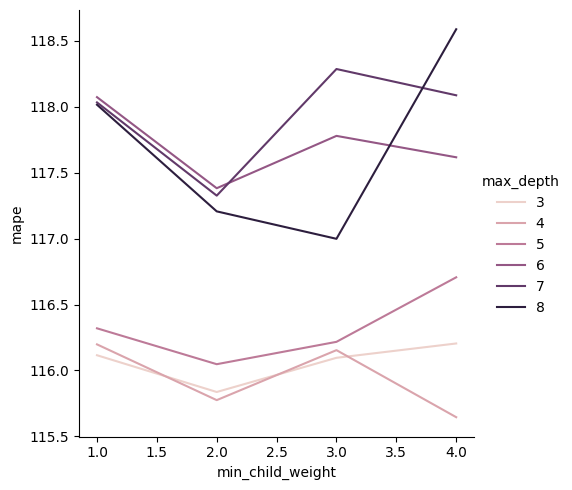

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

gs_results = grid_search.to_sklearn().cv_results_
max_depth_val = []
min_child_weight_val = []
for param_dict in gs_results["params"]:
    max_depth_val.append(param_dict["max_depth"])
    min_child_weight_val.append(param_dict["min_child_weight"])
mape_val = gs_results["mean_test_score"]*-1

gs_results_df = pd.DataFrame(data={
    "max_depth":max_depth_val,
    "min_child_weight":min_child_weight_val,
    "mape":mape_val})

sns.relplot(data=gs_results_df, x="min_child_weight", y="mape", hue="max_depth", kind="line")

plt.show()

In [7]:
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error

result = grid_search.predict(test_df)
mape = mean_absolute_percentage_error(df=result,
                                        y_true_col_names="COUNT",
                                        y_pred_col_names="PREDICTED_COUNT")

result.select("COUNT", "PREDICTED_COUNT").show()
print(f"Mean absolute percentage error: {mape}")

C:\Users\Preston\anaconda3\envs\python310\lib\site-packages\snowflake\ml\_internal\utils\snowpark_dataframe_utils.py:88: UserWarning: Warning: The Decimal(38, 2) data type is being automatically converted to DoubleType in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  warnings.warn(
C:\Users\Preston\anaconda3\envs\python310\lib\site-packages\snowflake\ml\_internal\utils\snowpark_dataframe_utils.py:88: UserWarning: Warning: The Decimal(38, 3) data type is being automatically converted to DoubleType in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  warnings.warn(
C:\Users\Preston\anaconda3\envs\python310\lib\site-packages\snowflake\ml\_internal\utils\snowpark_

-------------------------------
|"COUNT"  |"PREDICTED_COUNT"  |
-------------------------------
|1        |5                  |
|3        |-23                |
|36       |181                |
|94       |245                |
|106      |235                |
|93       |116                |
|37       |32                 |
|28       |42                 |
|39       |23                 |
|17       |39                 |
-------------------------------

Mean absolute percentage error: 0.69748060773


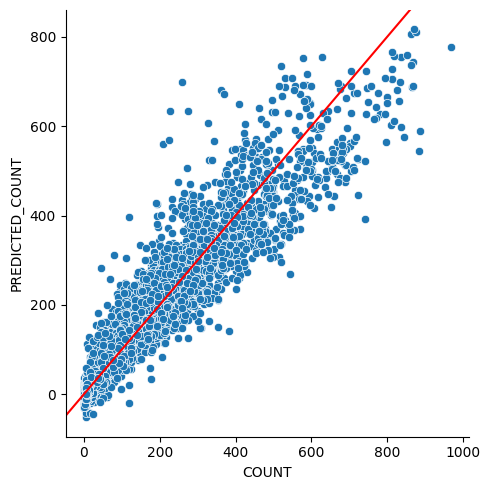

In [8]:
g = sns.relplot(data=result["COUNT", "PREDICTED_COUNT"].to_pandas().astype("float64"), x="COUNT", y="PREDICTED_COUNT", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

plt.show()

### Registering The Model


In [9]:
from snowflake.ml.registry import model_registry
registry = model_registry.ModelRegistry(session=session, database_name="SNOWPARK", schema_name="TUTORIAL", create_if_not_exists=True)

optimal_model = grid_search.to_sklearn().best_estimator_
optimal_max_depth = grid_search.to_sklearn().best_estimator_.max_depth
optimal_min_child_weight = grid_search.to_sklearn().best_estimator_.min_child_weight

optimal_mape = gs_results_df.loc[(gs_results_df['max_depth']==optimal_max_depth) &
                                 (gs_results_df['min_child_weight']==optimal_min_child_weight), 'mape'].values[0]

C:\Users\Preston\AppData\Local\Temp\ipykernel_23732\1417870892.py:2: DeprecationWarning: 
The `snowflake.ml.registry.model_registry.ModelRegistry` has been deprecated starting from version 1.2.0.
It will stay in the Private Preview phase. For future implementations, kindly utilize `snowflake.ml.registry.Registry`,
except when specifically required. The old model registry will be removed once all its primary functionalities are
fully integrated into the new registry.
        
  registry = model_registry.ModelRegistry(session=session, database_name="SNOWPARK", schema_name="TUTORIAL", create_if_not_exists=True)
create_model_registry() is in private preview since 0.2.0. Do not use it in production. 


In [10]:
from snowflake.ml._internal.utils import identifier 

X = train_df.select(FEATURE_LIST).limit(100) 

 

db = identifier._get_unescaped_name(session.get_current_database()) 

schema = identifier._get_unescaped_name(session.get_current_schema()) 


In [13]:
try:
    registry.delete_model(model_name="bike_model_xg_boost",
                model_version=1)
except:
    pass

In [14]:
model_name = "bike_model_xg_boost"
model_version = 1

registry.log_model(
    model_name=model_name,
    model_version=model_version,
    model=optimal_model,
    sample_input_data=X,
    options={"embed_local_ml_library": True, "relax": True})

registry.set_metric(model_name=model_name, model_version=model_version, metric_name="mean_abs_pct_err", metric_value=optimal_mape)

C:\Users\Preston\anaconda3\envs\python310\lib\contextlib.py:135: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  return next(self.gen)
C:\Users\Preston\anaconda3\envs\python310\lib\site-packages\snowflake\ml\model\model_signature.py:69: UserWarning: The sample input has 100 rows, thus a truncation happened before inferring signature. This might cause inaccurate signature inference. If that happens, consider specifying signature manually.
  warnings.warn(


In [15]:
#LIST MODELS IN THE REGISTRY

registry.list_models().to_pandas()

,CREATION_CONTEXT,CREATION_ENVIRONMENT_SPEC,CREATION_ROLE,CREATION_TIME,ID,INPUT_SPEC,NAME,OUTPUT_SPEC,RUNTIME_ENVIRONMENT_SPEC,TYPE,URI,VERSION,ARTIFACT_IDS,DESCRIPTION,METRICS,TAGS,REGISTRATION_TIMESTAMP
0,None,"{\n ""python"": ""3.10.11""\n}","""ACCOUNTADMIN""",2024-04-16 05:49:01.741000-07:00,ac88e6fdfbef11eeaab700e04c316b7e,None,bike_model_xg_boost,None,None,xgboost,sfc://SNOWPARK.TUTORIAL.SNOWML_MODEL_AC88E6FDF...,1,None,None,"{\n ""mean_abs_pct_err"": 115.64584045410156\n}",None,2024-04-16 05:49:02.829000-07:00


### Model Registry Method
* Code snippets covers all vital model registry methods. Methods include as following
* Set, get & remove tags / Set model description
* Ways to access registry history & finding evaluation metric
* Loading model from registry

In [17]:
#set tag for your model

registry.set_tag(model_name=model_name, model_version=model_version, tag_name="usage", tag_value="experiment")
registry.list_models().to_pandas()[["NAME", "TAGS"]]

,NAME,TAGS
0,bike_model_xg_boost,"{\n ""usage"": ""experiment""\n}"


In [18]:
#removing tag

registry.remove_tag(model_name=model_name, model_version=model_version, tag_name="usage")
registry.list_models().to_pandas()[["NAME", "TAGS"]]

,NAME,TAGS
0,bike_model_xg_boost,{}


In [19]:
#get tag value
registry.set_tag(model_name=model_name, model_version=model_version, tag_name="usage", tag_value="experiment")
print(registry.get_tag_value(model_name=model_name, model_version=model_version, tag_name="usage"))

#get all tags
print(registry.get_tags(model_name=model_name, model_version=model_version))

experiment
{'usage': 'experiment'}


In [20]:
#MODEL DESCRIPTION

registry.set_model_description(model_name=model_name, model_version=model_version, description="this is a test model")
print(registry.get_model_description(model_name=model_name, model_version=model_version))

this is a test model


In [21]:

#REGISTRY HISTORY
registry.get_history().to_pandas()

,EVENT_TIMESTAMP,EVENT_ID,MODEL_ID,ROLE,OPERATION,ATTRIBUTE_NAME,VALUE[ATTRIBUTE_NAME]
0,2024-04-10 07:03:45.892000-07:00,246b2a2ff74311eead3a00e04c316b7e,1dc54ee9f74311eea7b000e04c316b7e,"""ACCOUNTADMIN""",SET,REGISTRATION,"{\n ""CREATION_ENVIRONMENT_SPEC"": {\n ""pyth..."
1,2024-04-10 07:03:49.450000-07:00,268e43a4f74311ee828400e04c316b7e,1dc54ee9f74311eea7b000e04c316b7e,"""ACCOUNTADMIN""",SET,METRICS,"{\n ""mean_abs_pct_err"": 115.64584045410156\n}"
2,2024-04-10 07:05:39.683000-07:00,684251a2f74311eeb8d300e04c316b7e,1dc54ee9f74311eea7b000e04c316b7e,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
3,2024-04-10 07:05:42.563000-07:00,69f964fcf74311eeaccc00e04c316b7e,1dc54ee9f74311eea7b000e04c316b7e,"""ACCOUNTADMIN""",SET,TAGS,{}
4,2024-04-10 07:05:48.665000-07:00,6d9cf5f0f74311ee821500e04c316b7e,1dc54ee9f74311eea7b000e04c316b7e,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
5,2024-04-10 07:05:52.215000-07:00,6fbb6907f74311ee9c8a00e04c316b7e,1dc54ee9f74311eea7b000e04c316b7e,"""ACCOUNTADMIN""",SET,DESCRIPTION,"""this is a test model"""
6,2024-04-10 07:14:38.012000-07:00,a920798af74411ee8ec600e04c316b7e,1dc54ee9f74311eea7b000e04c316b7e,"""ACCOUNTADMIN""",SET,DELETION,"{\n ""URI"": ""sfc://SNOWPARK.TUTORIAL.SNOWML_MO..."
7,2024-04-10 07:14:58.850000-07:00,b58c0210f74411ee991f00e04c316b7e,af995dbef74411eeb72700e04c316b7e,"""ACCOUNTADMIN""",SET,REGISTRATION,"{\n ""CREATION_ENVIRONMENT_SPEC"": {\n ""pyth..."
8,2024-04-10 07:15:00.500000-07:00,b68860e4f74411ee920500e04c316b7e,af995dbef74411eeb72700e04c316b7e,"""ACCOUNTADMIN""",SET,METRICS,"{\n ""mean_abs_pct_err"": 115.64584045410156\n}"
9,2024-04-10 07:15:08.344000-07:00,bb348a86f74411ee854b00e04c316b7e,af995dbef74411eeb72700e04c316b7e,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"


In [22]:

#MODEL HISTORY
registry.get_model_history(model_name=model_name, model_version=model_version).to_pandas()

,EVENT_TIMESTAMP,EVENT_ID,MODEL_ID,ROLE,OPERATION,ATTRIBUTE_NAME,VALUE[ATTRIBUTE_NAME]
0,2024-04-16 05:49:02.829000-07:00,b3579b1ffbef11ee89ce00e04c316b7e,ac88e6fdfbef11eeaab700e04c316b7e,"""ACCOUNTADMIN""",SET,REGISTRATION,"{\n ""CREATION_ENVIRONMENT_SPEC"": {\n ""pyth..."
1,2024-04-16 05:49:05.172000-07:00,b4bd17affbef11ee805100e04c316b7e,ac88e6fdfbef11eeaab700e04c316b7e,"""ACCOUNTADMIN""",SET,METRICS,"{\n ""mean_abs_pct_err"": 115.64584045410156\n}"
2,2024-04-16 05:49:36.817000-07:00,c799a0d9fbef11eea0ab00e04c316b7e,ac88e6fdfbef11eeaab700e04c316b7e,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
3,2024-04-16 05:49:43.249000-07:00,cb6f0db1fbef11eeb55b00e04c316b7e,ac88e6fdfbef11eeaab700e04c316b7e,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
4,2024-04-16 05:49:45.050000-07:00,cc820a7bfbef11ee8a1800e04c316b7e,ac88e6fdfbef11eeaab700e04c316b7e,"""ACCOUNTADMIN""",SET,TAGS,{}
5,2024-04-16 05:49:46.876000-07:00,cd98ceb2fbef11eeb44a00e04c316b7e,ac88e6fdfbef11eeaab700e04c316b7e,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
6,2024-04-16 05:49:48.567000-07:00,ce9ad42bfbef11ee8aae00e04c316b7e,ac88e6fdfbef11eeaab700e04c316b7e,"""ACCOUNTADMIN""",SET,DESCRIPTION,"""this is a test model"""


In [23]:
#CHECK EVALUATION METRIC OF A MODEL

registry.get_metric_value(model_name=model_name, model_version=model_version, metric_name="mean_abs_pct_err")

115.64584045410156

In [24]:
#GET ALL METRICS STORED FOR A MODEL
registry.get_metrics(model_name=model_name, model_version=model_version)

{'mean_abs_pct_err': 115.64584045410156}

In [25]:
#load model from registry
xg_boost_model = registry.load_model(model_name=model_name, model_version=model_version)
xg_boost_model

C:\Users\Preston\anaconda3\envs\python310\lib\site-packages\snowflake\snowpark\_internal\utils.py:661: UserWarning: Please use with caution: Using `load_model` method requires you to have the EXACT same Python environments as the one when you logged the model. Any differences will potentially lead to errors.
Also, if your model contains custom code imported using `code_paths` argument when logging, they will be added to your `sys.path`. It might lead to unexpected module importing issues. If you run into such kind of problems, you need to restart your Python or Notebook kernel.
  return func(*args, **kwargs)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'int', 'int', 'int', 'int', 'int', 'float',
                            'float', 'float', 'int', 'int'],
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Deploying Model From Registry 

* Code snippet delineates steps involved in deployed model registered in model registry
* Also explains steps to predict using deployed models

In [26]:
#deploying a model from model registry
model_deployment_name = model_name + f"{model_version}" + "_UDF"

registry.deploy(model_name=model_name,
                model_version=model_version,
                deployment_name=model_deployment_name,
                target_method="predict",
                permanent=True,
                options={"relax_version": True})

RuntimeError: (2100) 
The model's dependencies are not available in Snowflake Anaconda Channel. 
Required packages are: "absl-py<2,>=1.4" "anyio<4,>=3.6" "cloudpickle<3,>=2.2" "numpy<2,>=1.24" "packaging<24,>=23.1" "pandas<2,>=1.5" "pyyaml<7,>=6.0" "snowflake-snowpark-python<2,>=1.14" "typing-extensions<5,>=4.11" "scikit-learn<2,>=1.3" "xgboost<2,>=1.7"
Required Python version is: 3.10
Packages that are not available are: []
Packages that cannot meet your requirements are: ['anyio', 'snowflake-snowpark-python', 'typing-extensions']
Package availability information of those you requested is: {'absl-py': [<Version('1.4.0')>], 'anyio': [], 'cloudpickle': [<Version('2.2.1')>], 'numpy': [<Version('1.24.3')>, <Version('1.25.0')>, <Version('1.25.2')>, <Version('1.26.0')>, <Version('1.26.2')>, <Version('1.26.3')>, <Version('1.26.4')>], 'packaging': [<Version('23.1')>, <Version('23.2')>], 'pandas': [<Version('1.5.1')>, <Version('1.5.2')>, <Version('1.5.3')>], 'pyyaml': [<Version('6.0')>, <Version('6.0.1')>], 'snowflake-snowpark-python': [], 'typing-extensions': [], 'scikit-learn': [<Version('1.3.0')>], 'xgboost': [<Version('1.7.3')>]}


In [27]:
#list all deployments for a model
registry.list_deployments(model_name, model_version).to_pandas()

,MODEL_NAME,MODEL_VERSION,DEPLOYMENT_NAME,CREATION_TIME,TARGET_METHOD,TARGET_PLATFORM,SIGNATURE,OPTIONS,STAGE_PATH,ROLE


In [28]:
model_ref = model_registry.ModelReference(registry=registry, model_name=model_name, model_version=model_version)
result_sdf = model_ref.predict(deployment_name=model_deployment_name, data=test_df)
result_sdf.show()

KeyError: "(0000) 'Unable to find deployment named bike_model_xg_boost1_UDF in the model bike_model_xg_boost/1.'"

### Delete Model From Deployment & Registry

In [ ]:
#delete deployment
registry.delete_deployment(model_name=model_name,
                model_version=model_version,
                deployment_name=model_deployment_name)
registry.list_deployments(model_name, model_version).to_pandas()

In [ ]:
#delete model from registry
registry.delete_model(model_name=model_name,
                model_version=model_version)
registry.list_models().to_pandas()